In [ ]:
# 1. Setup
!pip install kaggle
from google.colab import files
files.upload()  # Upload kaggle.json here

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 2. Download Dataset
!kaggle datasets download -d adityajn105/flickr8k --unzip


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1

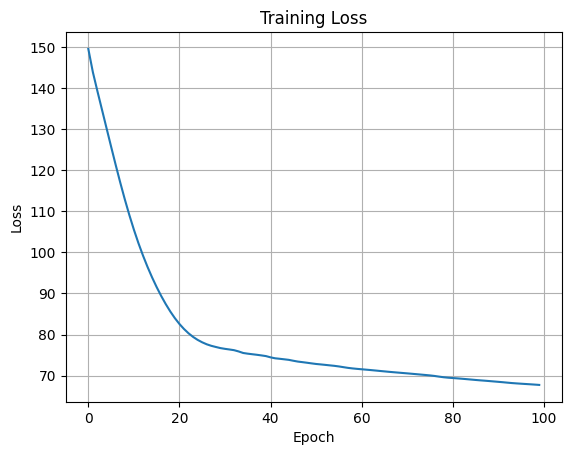

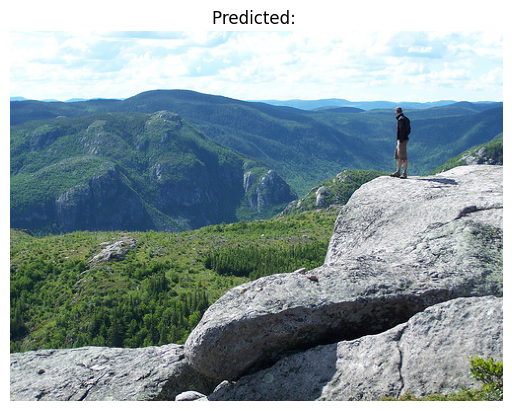

In [ ]:
# 3. Import neccessary libraries
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Model

# 4. Load Captions
df = pd.read_csv("/content/captions.txt")
df.columns = ["image", "caption"]
captions_dict = {}
for img, cap in df.values:
    cap = f"<GO> {cap.strip()} <STOP>"
    captions_dict.setdefault(img, []).append(cap)

# 5. Use 1000 images instead of 100
unique_images = list(captions_dict.keys())[:1000]
random.shuffle(unique_images)
train_imgs = unique_images[:700]
val_imgs = unique_images[700:900]
test_imgs = unique_images[900:]

def get_subset_data(img_list):
    return {img: captions_dict[img] for img in img_list}

train_caps = get_subset_data(train_imgs)
val_caps = get_subset_data(val_imgs)
test_caps = get_subset_data(test_imgs)

# 6. Tokenizer
# Prepare all captions with <GO> and <STOP> first
all_captions = []
for caps in train_caps.values():
    for cap in caps:
        all_captions.append(f"<GO> {cap.strip()} <STOP>")  # Add tokens here itself

# Now fit the tokenizer on those processed captions
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
tokenizer.fit_on_texts(all_captions)

# Now these tokens will be safely available
start_token = tokenizer.word_index["<go>"]  # case-insensitive usually
stop_token = tokenizer.word_index["<stop>"]
vocab_size = len(tokenizer.word_index) + 1


# 7. Image Preprocessing + Feature Extraction
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(299, 299))
    img = img_to_array(img)
    img = preprocess_input(img)
    return np.expand_dims(img, axis=0)

base_model = InceptionV3(include_top=False, weights='imagenet')
output = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
encoder_model = Model(base_model.input, output)

def encode_images(img_list):
    features = {}
    for img in img_list:
        img_path = os.path.join("/content/Images", img)
        img_tensor = preprocess_image(img_path)
        feat = encoder_model.predict(img_tensor)
        features[img] = feat.squeeze()
    return features

train_img_feats = encode_images(train_imgs)
val_img_feats = encode_images(val_imgs)
test_img_feats = encode_images(test_imgs)

# 8. Caption Encoding
def encode_captions(caps_dict):
    encoded_caps = []
    img_feats = []
    for img, caps in caps_dict.items():
        for cap in caps:
            seq = tokenizer.texts_to_sequences([cap])[0]
            seq = pad_sequences([seq], maxlen=20, padding='post')[0]
            encoded_caps.append(seq)
            img_feats.append(img)
    return np.array(encoded_caps), np.array(img_feats)

train_seqs, train_feat_keys = encode_captions(train_caps)
val_seqs, val_feat_keys = encode_captions(val_caps)
test_seqs, test_feat_keys = encode_captions(test_caps)

train_X = np.array([train_img_feats[k] for k in train_feat_keys])
val_X = np.array([val_img_feats[k] for k in val_feat_keys])
test_X = np.array([test_img_feats[k] for k in test_feat_keys])

# 9. Decoder Definition (LSTM)
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, units):
        super(Decoder, self).__init__()
        self.units = units
        self.embedding = Embedding(vocab_size, embedding_dim)
        self.lstm = LSTM(units, return_sequences=True, return_state=True)
        self.fc = Dense(vocab_size, activation='softmax')  # Apply softmax

        # Initialize hidden/cell state from image
        self.init_h = Dense(units)
        self.init_c = Dense(units)

    def call(self, x, enc_output):
        x = self.embedding(x)
        h = self.init_h(enc_output)
        c = self.init_c(enc_output)
        x, _, _ = self.lstm(x, initial_state=[h, c])
        x = self.fc(x)
        return x

embedding_dim = 256
units = 128
decoder = Decoder(vocab_size, embedding_dim, units)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.Adam()

# 10. Training Step
@tf.function
def train_step(img_feats, target):
    dec_input = tf.expand_dims([start_token] * target.shape[0], 1)
    loss = 0
    with tf.GradientTape() as tape:
        for t in range(1, target.shape[1]):
            predictions = decoder(dec_input, img_feats)
            loss += loss_object(target[:, t], predictions[:, -1, :])
            dec_input = tf.expand_dims(target[:, t], 1)
    gradients = tape.gradient(loss, decoder.trainable_variables)
    optimizer.apply_gradients(zip(gradients, decoder.trainable_variables))
    return loss

# 11. Training Loop for 100 epochs
losses = []
for epoch in range(100):
    total_loss = train_step(train_X, train_seqs)
    losses.append(total_loss.numpy())
    print(f"Epoch {epoch+1}, Loss: {total_loss.numpy():.4f}")

plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.show()

# 12. Caption Generation for 1 Image
def generate_caption(image_feature):
    dec_input = tf.expand_dims([start_token], 0)
    caption = []

    for _ in range(20):
        predictions = decoder(dec_input, image_feature)
        pred_id = tf.argmax(predictions[0, -1, :]).numpy()

        if pred_id == stop_token or pred_id == 0:
            break

        caption.append(pred_id)
        dec_input = tf.concat([dec_input, [[pred_id]]], axis=1)

    words = [word for word, idx in tokenizer.word_index.items() if idx in caption]
    return ' '.join(words)

# 13. Test a sample image
import PIL.Image
sample_img = test_feat_keys[0]
sample_feat = test_img_feats[sample_img].reshape(1, -1)

img_path = os.path.join("/content/Images", sample_img)
img_disp = PIL.Image.open(img_path)
pred_caption = generate_caption(sample_feat)

plt.imshow(img_disp)
plt.title(f"Predicted: {pred_caption}")
plt.axis('off')
plt.show()







 MODEL SUMMARY / THEORY

    # ✅ Encoder: InceptionV3 CNN used to extract fixed-length feature vectors from 299x299 images.
    # ✅ Decoder: An LSTM-based sequence generator that takes in the image embedding and predicts words step-by-step.
    # ✅ <GO> and <STOP>: Start and end tokens used to guide the sequence generation.
    # ✅ Loss: SparseCategoricalCrossentropy is used, summing over each predicted word.
    # ✅ Goal: Minimize the difference between ground truth caption and generated caption.
    # ✅ At Inference: The model generates a caption one word at a time, stopping when <STOP> is predicted.